In [131]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report
from textblob import TextBlob


# Data Prep

In [132]:
# Load Bank tablular data
csv_path = 'bank-data/bank-tabular.csv'
df_bankdata = pd.read_csv(csv_path, sep='\t')

df_bankdata


,customer_id,date,customer_gender,customer_age,customer_location,customer_type,has_cc,has_mortgage,convenience,customer_service,online_banking,interest_rates,fees_charges,community_involvement,products_services,privacy_security,reputation,satisfied
0,216604,2022-08-22,Male,50.0,Munster,Personal,True,False,4.0,5.0,4.0,4.0,4.0,4.0,5.0,2.0,4.0,True
1,259276,2022-11-23,Female,61.0,Leinster,Personal,True,False,5.0,5.0,5.0,3.0,5.0,4.0,4.0,5.0,5.0,True
2,265459,2022-01-21,Female,63.0,Munster,Business,True,False,2.0,2.0,5.0,5.0,2.0,NaN,4.0,4.0,NaN,True
3,58770,2022-03-13,f,NaN,Leinster,Business,True,False,NaN,4.0,5.0,1.0,5.0,5.0,5.0,5.0,5.0,True
4,318031,2022-08-08,Female,41.0,Leinster,Personal,True,True,1.0,1.0,1.0,1.0,2.0,2.0,4.0,5.0,2.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,322582,2021-09-23,Male,41.0,Munster,Personal,True,True,3.0,3.0,3.0,3.0,5.0,3.0,3.0,1.0,5.0,False
2996,53418,2021-03-07,f,57.0,Munster,Business,False,False,3.0,2.0,5.0,1.0,2.0,2.0,2.0,2.0,3.0,True
2997,79364,2021-08-01,m,NaN,Munster,Personal,True,True,3.0,3.0,3.0,4.0,4.0,3.0,4.0,4.0,4.0,False
2998,371134,2021-06-25,m,42.0,Leinster,Business,False,False,3.0,2.0,1.0,5.0,4.0,4.0,3.0,4.0,1.0,True


In [133]:
# Load Bank comments data
csv_path = 'bank-data/bank-comments.csv'
df = pd.read_csv(csv_path, sep='\t')

df


,customer_id,date,comments
0,216604,2022-08-22,"Overal, this bank is satisfactory."
1,259276,2022-11-23,Easy to find zhe bank ' s branches and ATMs. A...
2,265459,2022-01-21,Bank's phone app is really great. In general a...
3,58770,2022-03-13,NaN
4,318031,2022-08-08,NaN
...,...,...,...
2995,322582,2021-09-23,No comment
2996,53418,2021-03-07,Online banking is really good
2997,79364,2021-08-01,customer service quality from this bank is ter...
2998,371134,2021-06-25,Great to see that my bank supports local sport...


#### Bank comments clean up

In [134]:
# Clean data dealing with NaN's
# Enum satisfaction = [bad, neutral, good, unknown]

# def get_satisfaction(comments):
#     if pd.isna(comments):
#         return "neutral"
#     else:
#         return "unknown"

# apply function to DataFrame and assign result to new column
# df['satisfaction'] = df['comments'].apply(get_satisfaction)jj

#  drop NaN's
df['comments'] = df['comments'].fillna('neutral')

# print resulting DataFrame
df

,customer_id,date,comments
0,216604,2022-08-22,"Overal, this bank is satisfactory."
1,259276,2022-11-23,Easy to find zhe bank ' s branches and ATMs. A...
2,265459,2022-01-21,Bank's phone app is really great. In general a...
3,58770,2022-03-13,neutral
4,318031,2022-08-08,neutral
...,...,...,...
2995,322582,2021-09-23,No comment
2996,53418,2021-03-07,Online banking is really good
2997,79364,2021-08-01,customer service quality from this bank is ter...
2998,371134,2021-06-25,Great to see that my bank supports local sport...


In [135]:
# Iterate over the comments
for index, row in df.iterrows():
    # Get the comment from the current row
    comment = row["comments"]
    
    # Analyze the sentiment of the comment using TextBlob
    blob = TextBlob(comment)
    sentiment_score = blob.sentiment.polarity
    
    # Add the sentiment score to the "satisfaction" column of the current row
    df.at[index, "satisfaction"] = sentiment_score


In [136]:
df

,customer_id,date,comments,satisfaction
0,216604,2022-08-22,"Overal, this bank is satisfactory.",0.000000
1,259276,2022-11-23,Easy to find zhe bank ' s branches and ATMs. A...,0.616667
2,265459,2022-01-21,Bank's phone app is really great. In general a...,0.516667
3,58770,2022-03-13,neutral,0.000000
4,318031,2022-08-08,neutral,0.000000
...,...,...,...,...
2995,322582,2021-09-23,No comment,0.000000
2996,53418,2021-03-07,Online banking is really good,0.700000
2997,79364,2021-08-01,customer service quality from this bank is ter...,-0.666667
2998,371134,2021-06-25,Great to see that my bank supports local sport...,0.360000


In [137]:
# given the following columns of a dataframe customer_id	
# date	customer_gender	customer_age	customer_location
# customer_type	has_cc	has_mortgage	convenience	customer_service	
# online_banking	interest_rates	fees_charges	community_involvement	
# products_services	privacy_security	reputation	satisfied. how can we 
# predict satisfaction which i a boolean property true/false. Lets do some test_train split



In [138]:
# date is not a relevant predictor 
df_bankdata = df_bankdata.drop('date', axis=1)

In [139]:
# get all unique gender possibilities 
print(df_bankdata['customer_gender'].unique())
print(df_bankdata['customer_age'].unique())
print(df_bankdata['customer_location'].unique())
print(df_bankdata['customer_type'].unique())



['Male' 'Female' 'f' 'Unspecified' nan 'm' 'Not specified']
[50. 61. 63. nan 41. 71. 40. 46. 65. 69. 56. 51. 52. 54. 31. 35. 32. 43.
 42. 55. 29. 60. 53. 62. 72. 27. 24. 49. 67. 73. 57. 37. 34. 78. 45. 59.
 19. 39. 75. 44. 58. 23. 48. 64. 68. 47. 30. 22. 76. 18. 33. 26. 28. 36.
 92. 66. 77. 79. 21. 20. 25. 70. 81. 74. 38. 80. 88. 83. 82. 91. 86. 84.]
['Munster' 'Leinster' nan 'Connacht' 'Ulster']
['Personal' 'Business' 'Business-Plus']


In [140]:

# replace all NaN values with 2 in the 'gender' column
df_bankdata['customer_gender'] = df_bankdata['customer_gender'].fillna(2)

# hot encode gender as a numerical value male=1, female=0, unknown=2 
# replace multiple values in the 'gender' column
df_bankdata['customer_gender'] = df_bankdata['customer_gender'].replace({'Male': 1, 'Female': 0, 'f': 0, 'm': 1, 'Unspecified': 2, 'Not specified': 2, 'nan':2}).astype(int)



In [144]:
# test to find out what to do with customer age nan values
df_bankdata
median_age = df_bankdata['customer_age'].median()
mean_age = df_bankdata['customer_age'].mean()
mode_age = df_bankdata['customer_age'].mode()
print(mean_age, median_age, mode_age)
# Since the mean, median and mode are close together we can see normal distribution of customer age. 
# Thus, a good way to solve nan age values is to replace it with the mean average age. 

47.28181818181818 48.0 0    48.0
Name: customer_age, dtype: float64


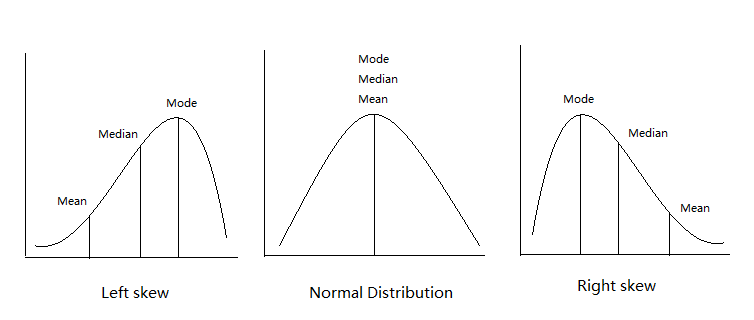
Since the mean, median and mode are close together we can see normal distribution of customer age. Thus, a good way to solve nan age values is to replace it with the mean average age. 

In [145]:
# then use age bins to hot encode age in to categories 


In [146]:


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_bankdata.drop('satisfied', axis=1), df_bankdata['satisfied'], test_size=0.2, random_state=42)

# Create a logistic regression model and fit it to the training data
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict the customer satisfaction on the test data
y_pred = model.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)


ValueError: could not convert string to float: 'Leinster'